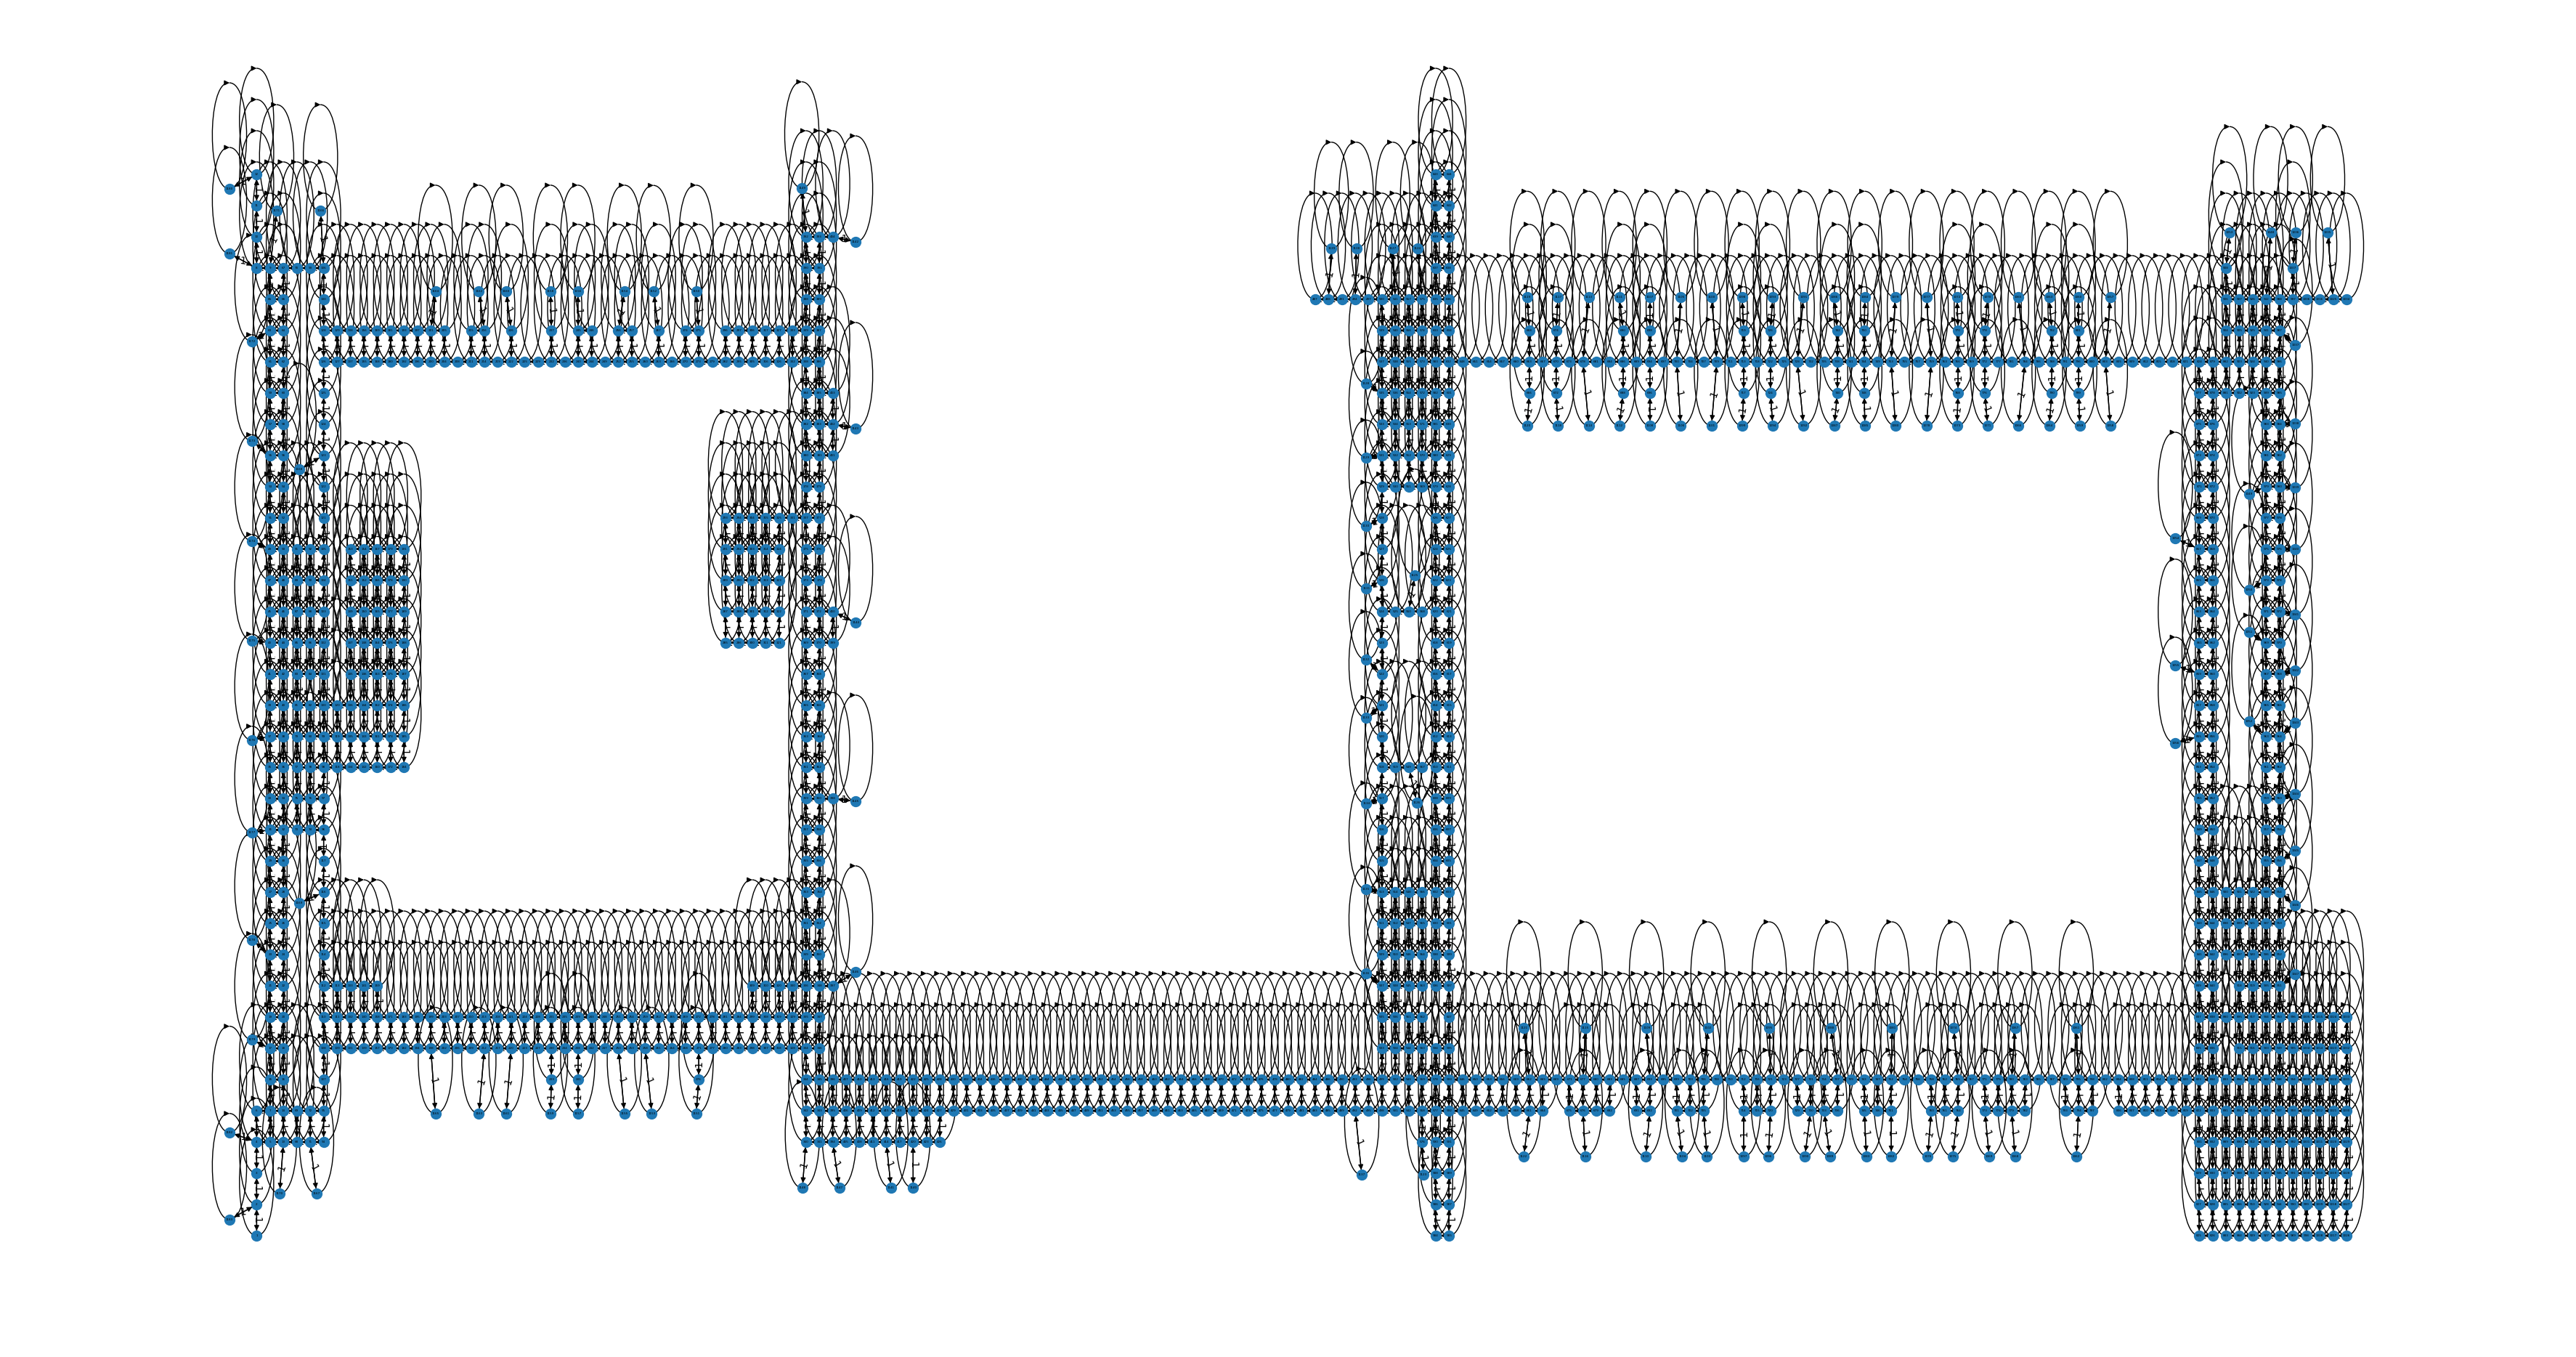

In [1]:
import json
import os
import random
import sys

import networkx as nx
import matplotlib.pyplot as plt


agents = [2,4,8]
goals = [0,1,5,10]
MAPF = "CBS"
SAPF = "TDSP"
costFunction = "SIC"
heuristic = ""


def drawGraph(G):
    labeldict = {}
    for node in G.nodes:
        labeldict[node] = G.nodes[node]["name"]

    plt.figure(figsize=(4096/90, 2160/90))
    labels = nx.get_edge_attributes(G,'weight')
    nx.draw_networkx_edge_labels(G, nx.get_node_attributes(G, 'pos'), edge_labels=labels)
    nx.draw(G, nx.get_node_attributes(G, 'pos'), labels = labeldict, with_labels=True, node_size = 100, font_size = 3)
    plt.show()


def saveGraphImage(filename, G):
    labeldict = {}
    for node in G.nodes:
        labeldict[node] = G.nodes[node]["name"]

    labels = nx.get_edge_attributes(G,'weight')
    plt.figure(figsize=(4096/90, 2160/90))
    nx.draw_networkx_edge_labels(G,nx.get_node_attributes(G, 'pos'),edge_labels=labels)
    nx.draw(G, nx.get_node_attributes(G, 'pos'), labels = labeldict, with_labels=True, node_size = 10000, font_size = 20)
    plt.savefig(filename+".pdf", dpi = 1200, orientation = "landscape", transparent = False)
    # plt.savefig(filename+".png", dpi = 1200, orientation = "landscape", transparent = False)


def getGraphFromJson(filename = "graph.json"):
    G = nx.DiGraph()
    with open (filename, "r") as fileJson:
        data = json.load(fileJson)
        for v in data["nodes"]:
            G.add_node(v[1], pos=(v[2], v[3]), name=v[0])

        for row in range(len(data["connect"])):
            for col in range(len(data["connect"][row])):
                if data["connect"][row][col] == 1:
                    G.add_edge(row, col, weight=data["connect"][row][col])

    # Add links to make it connected
    G.add_edge(135, 144, weight=1)
    G.add_edge(143, 145, weight=1)
    G.add_edge(161, 162, weight=1)
    G.add_edge(173, 174, weight=1)
    G.add_edge(185, 186, weight=1)
    G.add_edge(144, 135, weight=1)
    G.add_edge(145, 143, weight=1)
    G.add_edge(162, 161, weight=1)
    G.add_edge(174, 173, weight=1)
    G.add_edge(186, 185, weight=1)

    drawGraph(G)
    return G


def extractBuilding1(G : nx.DiGraph):
    if not os.path.isdir("maps/build1"):
        os.mkdir("maps/build1")

    build = nx.DiGraph()
    nodeMap = {}
    for node in G.nodes:
        if G.nodes[node]["pos"][0] < 74:
            build.add_node(len(build.nodes), pos=G.nodes[node]["pos"], name=G.nodes[node]["name"])
            nodeMap[node] = len(build.nodes) - 1

    for edge in G.edges:
        if edge[0] in nodeMap and edge[1] in nodeMap:
            if nodeMap[edge[0]] in build.nodes and nodeMap[edge[1]] in build.nodes:
                build.add_edge(nodeMap[edge[0]], nodeMap[edge[1]], weight=G.edges[edge]["weight"])

    saveGraphImage("maps/build1/build1", build)
    if nx.is_strongly_connected(build):
        print("Build1 connected")
    else:
        print("Build 1 not connected")

    return build


def extractBuilding2(G : nx.DiGraph):
    if not os.path.isdir("maps/build2"):
        os.mkdir("maps/build2")
    build = nx.DiGraph()
    nodeMap = {}
    for node in G.nodes:
        if G.nodes[node]["pos"][0] > 109:
            build.add_node(len(build.nodes), pos=G.nodes[node]["pos"], name=G.nodes[node]["name"])
            nodeMap[node] = len(build.nodes) - 1

    for edge in G.edges:
        if edge[0] in nodeMap and edge[1] in nodeMap:
            if nodeMap[edge[0]] in build.nodes and nodeMap[edge[1]] in build.nodes:
                build.add_edge(nodeMap[edge[0]], nodeMap[edge[1]], weight=G.edges[edge]["weight"])

    saveGraphImage("maps/build2/build2", build)
    if nx.is_strongly_connected(build):
        print("Build 2 connected")
    else:
        print("Build 2 not connected")

    return build



def extractBridge(G : nx.DiGraph):
    if not os.path.isdir("maps/bridge"):
        os.mkdir("maps/bridge")
    build = nx.DiGraph()
    nodeMap = {}
    for node in G.nodes:
        if G.nodes[node]["pos"][0] < 109 and G.nodes[node]["pos"][0] > 73:
            build.add_node(len(build.nodes), pos=G.nodes[node]["pos"], name=G.nodes[node]["name"])
            nodeMap[node] = len(build.nodes) - 1

    for edge in G.edges:
        if edge[0] in nodeMap and edge[1] in nodeMap:
            if nodeMap[edge[0]] in build.nodes and nodeMap[edge[1]] in build.nodes:
                build.add_edge(nodeMap[edge[0]], nodeMap[edge[1]], weight=G.edges[edge]["weight"])

    saveGraphImage("maps/bridge/bridge", build)
    if nx.is_strongly_connected(build):
        print("Bridge connected")
    else:
        print("Bridge not connected")

    return build


def createRandom(G : nx.DiGraph, outputDir : str):
    if not os.path.isdir(outputDir):
        os.mkdir(outputDir)

    data = dict()
    data["MAPF"] = MAPF
    data["SAPF"] = SAPF
    data["costFunction"] = costFunction
    data["heuristic"] = heuristic
    data["nNodes"] = len(G.nodes)
    data["nodes"] = []
    for node in G.nodes:
        data["nodes"].append((G.nodes[node]["name"], G.nodes[node]["pos"][0], G.nodes[node]["pos"][1], node))
    data["connect"] = nx.adjacency_matrix(G, nodelist=sorted(G.nodes)).todense().tolist()

    counter = 0

    for nAgents in agents:
        if nAgents >= len(data["nodes"]):
            print("Skipping nAgents = " + str(nAgents) + " because it is too big")
            continue
        data["nAgents"] = nAgents
        data["agents"] = [{} for a in range(nAgents)]
        initPos = random.sample(list(data["nodes"]), nAgents)
        endPos = []
        if nAgents > 50 * len(data["nodes"]) / 100.0:
            endPos = initPos
        else:
            endPos = random.sample([n for n in data["nodes"] if n not in initPos], nAgents)

        for a in range(nAgents):
            data["agents"][a]["ID"] = a
            data["agents"][a]["initPos"] = initPos[a]
            data["agents"][a]["endPos"] = endPos[a]

        for nGoals in goals:
            nonEndPos = [n for n in data["nodes"] if n not in endPos]
            for a in range(nAgents):
                data["agents"][a]["goalPos"] = []
                if nGoals > 0:
                    data["agents"][a]["goalPos"].append(random.choice(nonEndPos))
                for i in range(1, nGoals):
                    tmp = random.choice(nonEndPos)
                    while tmp == data["agents"][a]["goalPos"][-1]:
                        tmp = random.choice(nonEndPos)
                    data["agents"][a]["goalPos"].append(tmp)

            # Make sure that no goalPos is also an endPos
            for a in range(nAgents):
                for n in data["agents"][a]["goalPos"]:
                    if n in endPos:
                        raise Exception("goalPos is already an endPos")

            with open("temp.json", "w+") as output:
                json.dump(data, output, indent = 2)

            with open("temp.json", "r") as temp:
                with open(os.path.join(outputDir, str(counter)+".json"), "w+") as output:
                    for line in temp:
                        if any(x in line for x in ["{" , "}", "nNodes", "nodes", "connect", "]", "MAPF", "SAPF", "costFunction", "heuristic", "nAgents", "ID", "goalPos"]):
                            output.write(line)
                        else:
                            line = line.split("\n")[0]
                            output.write(line)

            os.remove("temp.json")

            counter += 1
            print(counter, end="\r")


if __name__ == "__main__":
    random.seed(1)  # for repeatability
    if not os.path.isdir("maps"):
        os.mkdir("maps")
    if not os.path.isdir("maps/uni"):
        os.mkdir("maps/uni")

    G = getGraphFromJson()
    # createRandom(G, "maps/uni/output")
    # build1 = extractBuilding1(G)
    # createRandom(build1, "maps/build1/output")
    # bridge = extractBridge(G)
    # createRandom(bridge, "maps/bridge/output")
    # build2 = extractBuilding2(G)
    # createRandom(build2, "maps/build2/output")


In [2]:
adj_matrix=nx.adjacency_matrix(G).todense()
edge_weights = nx.get_edge_attributes(G, 'weight')


In [758]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class HebbianGNN(nn.Module):
    def __init__(self, num_nodes, input_dim, hidden_dim, eta=0.1, B=0.1, C=0.01, D=0.01):
        super(HebbianGNN, self).__init__()
        self.num_nodes = num_nodes
        self.hidden_dim = hidden_dim
        self.eta = eta  # Hebbian learning rate
        self.B = B  # Baseline decay factor
        self.C = C  # Competition factor
        self.D = D  # Differentiation factor

        # Node embedding layer
        self.node_embed = nn.Linear(input_dim, hidden_dim)
        # Hebbian weight matrix (initialized as zeros)
        self.W = torch.zeros((num_nodes, num_nodes), requires_grad=False)  # Adjacency-like weight matrix
        
        # Output layer for action selection
        self.output_layer = nn.Linear(hidden_dim, num_nodes)
    
    def forward(self, node_features, adjacency_matrix):
        """
        node_features: [num_nodes, input_dim] -> Features for each node
        adjacency_matrix: [num_nodes, num_nodes] -> Graph connectivity
        """
        # Compute node embeddings
        x = F.relu(self.node_embed(node_features))  # [num_nodes, hidden_dim]
        # Apply ABCD Hebbian learning update
        self.W = self.hebbian_update(self.W, x)
        # Graph propagation using updated weights
        x = torch.matmul(self.W, x.T)  # [num_nodes, hidden_dim]
       
        # Output layer predicts next move
        out = self.output_layer(x)  # [num_nodes, num_nodes]
        #print(out)    
        
        return out  # Probability distribution over next positions

    def hebbian_update(self, W, x):
        """
        ABCD Hebbian update rule:
        W_new = W + eta * (A - B * W + C * sum(W_row) - D * sum(W_col))
        - A: Activity-Dependent (Hebbian Learning)
        - B: Baseline Decay
        - C: Competition (Row-wise Sum)
        - D: Differentiation (Column-wise Sum)
        """
        A = torch.matmul(x, x.T)  # Hebbian correlation
        W_new = W + self.eta * (
            A                          # A: Activity-dependent term
            - self.B * W               # B: Baseline weight decay
            + self.C * torch.sum(W, dim=1, keepdim=True)  # C: Competition
            - self.D * torch.sum(W, dim=0, keepdim=True)  # D: Differentiation
        )

        # Ensure no self-loops (diagonal elements should be 0)
        W_new.fill_diagonal_(0)
        return W_new

    def reset_weights(self):
        """Reset Hebbian weights (useful between training episodes)."""
        self.W = torch.zeros((self.num_nodes, self.num_nodes), requires_grad=False)


In [6]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class HebbianGNN(nn.Module):
    def __init__(self, num_nodes, input_dim, hidden_dim, eta=0.01, B=0.1, C=0.01, D=0.01):
        super(HebbianGNN, self).__init__()
        self.num_nodes = num_nodes
        self.hidden_dim = hidden_dim
        self.eta = eta  # Hebbian learning rate
        self.B = B  # Baseline decay factor
        self.C = C  # Competition factor
        self.D = D  # Differentiation factor
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        # Node embedding layer (learns input feature transformations)
        self.node_embed = nn.Linear(input_dim, hidden_dim)

        # Hebbian weight matrix (learned dynamically)
        self.W = torch.zeros((num_nodes, num_nodes), requires_grad=False).to(device)  # Adjacency-like weight matrix

        # Graph Convolution Layer (instead of basic linear layer)
        # self.gnn_layer = nn.Linear(hidden_dim, hidden_dim)

        # Output layer for action selection
        self.output_layer = nn.Linear(hidden_dim, num_nodes)

    def forward(self, node_features, adjacency_matrix,reward):
        """
        node_features: [num_nodes, input_dim] -> Features for each node
        adjacency_matrix: [num_nodes, num_nodes] -> Graph connectivity
        """
        # Compute node embeddings
        device=torch.device("cuda" if torch.cuda.is_available() else "cpu")
        node_features = node_features.to(device)
        adjacency_matrix = adjacency_matrix.to(device)
        x = F.relu(self.node_embed(node_features)).to(device)  # [num_nodes, hidden_dim]
        # Apply ABCD Hebbian learning update
        self.W = self.hebbian_update(self.W, x,reward).to(device)
        # Message Passing: Update adjacency matrix dynamically
        updated_adj = adjacency_matrix * self.W # Integrate learned connectivity

        # Normalize adjacency matrix (avoid explosion of values)
        updated_adj = self.normalize(updated_adj)

        # Graph Propagation: Aggregate features from neighbors
        x = torch.matmul(updated_adj, x)  # [num_nodes, hidden_dim]
        # x = F.relu(self.gnn_layer(x))  # GNN transformation

        # Output layer predicts next move
        out = self.output_layer(x)  # [num_nodes, num_nodes]
        return F.softmax(out, dim=1)  # Probability distribution over next positions

    def hebbian_update(self, W, x,reward):
        """
        ABCD Hebbian update rule:
        W_new = W + eta * (A - B * W + C * sum(W_row) - D * sum(W_col))
        - A: Activity-Dependent (Hebbian Learning)
        - B: Baseline Decay
        - C: Competition (Row-wise Sum)
        - D: Differentiation (Column-wise Sum)
        """
        A = torch.matmul(x, x.T).to("cuda")  # Hebbian correlation
        W=W.to("cuda")    
      
        W_new = W + self.eta *reward* (
            A                          # A: Activity-dependent term
            + self.B * W               # B: Baseline weight decay
            + self.C * torch.sum(W, dim=1, keepdim=True).to("cuda")  # C: Competition
            + self.D * torch.sum(W, dim=0, keepdim=True).to("cuda")  # D: Differentiation
        )
        W_new.to("cuda")

        # Ensure no self-loops (diagonal elements should be 0)
        W_new.fill_diagonal_(0)
        return W_new.to("cuda")

    def normalize(self, A):
        """Row-normalize adjacency matrix for stability"""
        row_sum = A.sum(dim=1, keepdim=True) + 1e-6  # Avoid division by zero
        return A / row_sum

    def reset_weights(self):
        """Reset Hebbian weights (useful between episodes)."""
        self.W = torch.zeros((self.num_nodes, self.num_nodes), requires_grad=False)


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class NeuronCentricHebbianGNN(nn.Module):
    def __init__(self, num_nodes, input_dim, hidden_dim,adj_matrix, eta=0.001):
        super(NeuronCentricHebbianGNN, self).__init__()
        self.num_nodes = num_nodes
        self.hidden_dim = hidden_dim
        self.eta = eta  # Global learning rate
        
        # Device configuration
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

        # Node embedding layer
        self.node_embed = nn.Linear(input_dim, hidden_dim)

        # Initialize neuron-specific Hebbian parameters
        self.A=nn.Parameter(torch.ones(hidden_dim, device=self.device)*0.1)
        self.B=nn.Parameter(torch.ones(hidden_dim, device=self.device)*0.1)
        self.C=nn.Parameter(torch.ones(hidden_dim, device=self.device)*0.01)
        self.D=nn.Parameter(torch.ones(hidden_dim, device=self.device)*0.01)
        # self.A = nn.Parameter(torch.randn(hidden_dim, device=self.device))  # Learning rate for each neuron
        # self.B = nn.Parameter(torch.randn(hidden_dim, device=self.device))  # Decay rate for each neuron
        # self.C = nn.Parameter(torch.randn(hidden_dim, device=self.device))  # Competition term for each neuron
        # self.D = nn.Parameter(torch.randn(hidden_dim, device=self.device))  # Differentiation term for each neuron

        # Hebbian weight matrix (learned dynamically)
        self.W = torch.zeros((num_nodes, num_nodes), device=self.device, requires_grad=False)

        # Graph Convolution Layer
        self.gnn_layer = nn.Linear(hidden_dim, hidden_dim)

        # Output layer for action selection
        self.output_layer = nn.Linear(hidden_dim, num_nodes)
        self.gnn_layer.weight.data *= adj_matrix
        self.output_layer.weight.data *= adj_matrix

    def forward(self, node_features, adjacency_matrix, reward,node_number):
        """
        node_features: [num_nodes, input_dim] -> Features for each node
        adjacency_matrix: [num_nodes, num_nodes] -> Graph connectivity
        reward: scalar value representing the reward signal
        """
        # Ensure inputs are on the proper device
        node_features = node_features.to(self.device)
        adjacency_matrix = adjacency_matrix.to(self.device)
        
        # 1. Compute node embeddings from input features.
        x = F.sigmoid(self.node_embed(node_features))  # [num_nodes, hidden_dim]
        
        # 2. Clone the current activations to serve as "previous" activations.
        x_prev = x.clone()
        x = F.tanh(self.gnn_layer(x))

        # deltaW= self.hebbian_update(self.gnn_layer.weight.data, x, x_prev, reward)*adjacency_matrix

        # self.W[node_number,:]= self.W[node_number,:]+deltaW[node_number,:]
        # self.gnn_layer.weight.data = self.gnn_layer.weight.data + deltaW
        # 3. Apply the neuron-centric Hebbian update using the current and previous activations, modulated by reward.
        #    This update adjusts the Hebbian weight matrix based on the latest activity and the reward signal.
        # 4. Integrate the learned Hebbian weights with the original graph connectivity.
        #    Here we update the dynamic adjacency matrix.
        # updated_adj = adjacency_matrix * self.W
        
        # 5. Normalize the updated adjacency matrix for numerical stability.
        # updated_adj = self.normalize(updated_adj)
        
        # 6. Perform graph propagation: aggregate features from neighboring nodes.
        # x = torch.matmul(self.W, x)  # [num_nodes, hidden_dim]
        
        # 7. Compute the output via the final layer.
        out = F.tanh(self.output_layer(x))  # [num_nodes, num_nodes]
        # deltaW = self.hebbian_update(self.output_layer.weight.data, out, x, reward)*adjacency_matrix
        # self.output_layer.weight.data = self.output_layer.weight.data + deltaW
        # 8. Optionally, mask the output with the original adjacency if needed.
     
        
        # 9. Return the softmax over outputs as the probability distribution of next moves.
        return F.softmax(out, dim=1),x_prev,x,out
        # return F.softmax(out, dim=1),x,out
    def update_weights(self, reward,x_prev,x,out,adjacency_matrix,position,target):
        """
        Update the weights of the Hebbian weight matrix for a specific node.
        """
        def norm_scaling(W):
            norm = torch.norm(W, p=2)
            return 1.0 / (1.0 + norm)
        lambda_decay=0.01
        flag_same= (position==target)
        # alpha can and should be tuned
        postout = torch.zeros_like(out[position])
        postout[target] = 1.0
        post_gnn=(x[position])
    
        # if flag_same:
        # self.output_layer.weight.data[target,target]+=deltaW[target,target]-lambda_decay*reward*self.output_layer.weight.data[target,target]
        
        conected_ones = torch.zeros_like(adjacency_matrix, dtype=torch.bool)
        row_mask = adjacency_matrix[position, :] == 1
        col_mask = adjacency_matrix[:, position] == 1
        conected_ones[position, :] = row_mask
        conected_ones[:, position] |= col_mask


        indices = torch.nonzero(conected_ones, as_tuple=False)
        conn_to_conn= torch.zeros_like(conected_ones, dtype=torch.bool)
        for i in torch.unique(indices).cpu().numpy():
            conn_to_conn|=adjacency_matrix[i,:]==1
            conn_to_conn|=adjacency_matrix[:,i]==1
        # filtered = indices[indices[:, 0] != indices[:, 1]]
    # Step 4: Get unique node indices from those pairs
        deltaW = self.hebbian_update(self.output_layer.weight.data, out, x, reward,flag_same)*conected_ones
        scale_factor = norm_scaling(self.output_layer.weight.data)
        self.output_layer.weight.data+= scale_factor*deltaW -lambda_decay*self.output_layer.weight.data
        # self.normalize_weights_rowwise(self.output_layer.weight.data)
        # introducing a gate (like dopamine in brains) that scales updates based on performance over time.
        # active_node_mask = torch.zeros_like(self.output_layer.weight.data)
        
        deltaW= self.hebbian_update(self.gnn_layer.weight.data, x, x_prev, reward,flag_same)*conn_to_conn
        scale_factor = norm_scaling(self.gnn_layer.weight.data)
        self.gnn_layer.weight.data+= scale_factor*deltaW - lambda_decay*reward*self.gnn_layer.weight.data
        # self.normalize_weights_rowwise(self.gnn_layer.weight.data)
        # self.gnn_layer.weight.data[position,target]+= deltaW[position,target] - lambda_decay*reward*self.output_layer.weight.data[position,target]

        # else:
        #     lambda_decay=0.01
        #     deltaW = self.hebbian_update(self.output_layer.weight.data, out, x, reward,flag_same)*adjacency_matrix
        #     scale_factor = norm_scaling(self.output_layer.weight.data)
        #     # self.output_layer.weight.data[target,target]+= deltaW[target,target] -lambda_decay*self.output_layer.weight.data[target,target]
        #     self.output_layer.weight.data+= scale_factor*deltaW-lambda_decay*self.output_layer.weight.data

        #     # activated_hidden_neurons = out[target, :]
        #     # mask_hidden = (activated_hidden_neurons != 0.0).float().unsqueeze(1)  # Mask for active neurons

        #     # Hebbian update for the specific node

        #     deltaW= self.hebbian_update(self.gnn_layer.weight.data, x, x_prev, reward,flag_same)*adjacency_matrix
        #     scale_factor = norm_scaling(self.gnn_layer.weight.data)
        #     self.gnn_layer.weight.data+= scale_factor*deltaW - lambda_decay*reward*self.gnn_layer.weight.data

        #     # print(deltaW[deltaW<0].shape)

        #     # self.W[node_number,:]= self.W[node_number,:]+deltaW[node_number,:]
        #     # self.gnn_layer.weight.data += deltaW*mask_hidden

            # self.gnn_layer.weight.data[position,target]+= deltaW[position,target] -lambda_decay*self.output_layer.weight.data[position,target]

    def get_weights(self):
        """
        returns weights """
        return [self.gnn_layer.weight.data, self.output_layer.weight.data]


    def set_update_rules(self,hrules: list):
        """
        Returns the Hebbian update rules for each neuron.
        """
        start = 0
        for l in self.get_weights():
            size = l.size()[0] * l.size()[1] * 4 + start
            params = torch.tensor(hrules[start:size])
            self.hrules.append(torch.reshape(params, (l.size()[0], l.size()[1], 4)))
            start = size



    def hebbian_update(self, W, x,x_prev, reward,flag_same):
        """
        Implements the Hebbian update rule:
        ΔW_ij = η_ij ( A_ij * a_i + B_ij * a_j + C_ij * a_i * a_j + D_ij )
        """
        # Compute activations
        a_i = x_prev  # Shape: [num_nodes, 1, hidden_dim]
        a_j = x  # Shape: [1, num_nodes, hidden_dim]
        # gate = (torch.tanh(torch.tensor(reward* alpha))) / 2  # In [0, 1]

        # activity_mask =(a_i != 0).float().T @ (a_j != 0).float()

        hebbian_term = torch.matmul(a_i, a_j.T) 
        # C_param=self.C if not flag_same else -self.C
        # Compute the Hebbian weight update based on the equation
        delta_W =self.eta *reward* (
            self.A.view(-1, 1) * a_i.T +  # A_ij * a_i
            self.B.view(-1, 1)* a_j.T +  # B_ij * a_j
            self.C.view(-1, 1) * hebbian_term  # C_ij * a_i * a_j
             + self.D.view(-1, 1)  # D_ij
        )
        oja_decay = self.eta * (a_j ** 2) * W

        # Final update
        delta_W +=  oja_decay
        # Update weights
        # W_new = W + delta_W  # Summing over hidden_dim to get [num_nodes, num_nodes]

        # Ensure no self-loops
        # if not flag_same:
            # delta_W.fill_diagonal_(0.0)
        return delta_W

    # # def hebbian_update(self, W, x, reward):
    # #     """
    # #     Neuron-centric Hebbian update rule:
    # #     ΔW_ij = η * reward * (A_i * x_i * x_j - B_i * W_ij + C_i * sum(W_i*) - D_i * sum(W_*j))
    # #     """
    # #     # Compute outer product of activations (Hebbian term)
    # #     hebbian_term = torch.matmul(x, x.T)  # [num_nodes, num_nodes]

    # #     # Apply neuron-centric Hebbian update
    # #     W_new = W.clone()
    # #     # for i in range(self.num_nodes):
    # #     #     for j in range(self.num_nodes):
    # #     #         delta_w = (self.A[i] * hebbian_term[i, j] -
    # #     #                    self.B[i] * W[i, j] +
    # #     #                    self.C[i] * torch.sum(W[i, :]) -
    # #     #                    self.D[i] * torch.sum(W[:, j]))
    # #     #         W_new[i, j] += self.eta * reward * delta_w

    # #     W_new = W + self.eta * reward * (
    # #         self.A.view(-1, 1) * hebbian_term   # Activity-dependent term
    # #         +self.B.view(-1, 1) * hebbian_term            # Baseline decay
    # #         + self.C.view(-1, 1) * hebbian_term   # Competition
    # #         + self.D.view(1, -1)    # Differentiation
    # #     )
    # #     # Ensure no self-loops (diagonal elements should be 0)
    # #     W_new.fill_diagonal_(0)
    # #     return W_new

    # def normalize(self, A):
    #     """Row-normalize adjacency matrix for stability"""
    #     row_sum = A.sum(dim=1, keepdim=True) + 1e-6  # Avoid division by zero
    #     return A / row_sum

    def normalize_weights_rowwise(self,W):
        """Normalize incoming weights per neuron so that each neuron's weights sum to 1."""
        with torch.no_grad():
            W_sum = W.sum(dim=0, keepdim=True) + 1e-8  # Avoid division by zero
            W.div_(W_sum)


    def reset_weights(self):
        """Reset Hebbian weights (useful between episodes)."""
        self.W = torch.zeros((self.num_nodes, self.num_nodes), device=self.device, requires_grad=False)


In [165]:
from sklearn.preprocessing import OneHotEncoder
import numpy as np
class Agent:
    def __init__(self, data,num_nodes):
        self.id = data["ID"]
        self.init_pos = data["initPos"][0]
        self.end_pos = data["endPos"][0]
        self.goal_pos = data["goalPos"][0] if len(data["goalPos"])>0 else None
        self.num_nodes=num_nodes
        self.current_pos = self.init_pos
        self.window_size=10
        self.path = [self.init_pos]
        self.shortest_path_lengths = dict(nx.all_pairs_shortest_path_length(G))
    def __str__(self):
        return f"Agent(id={self.id}, init_pos={self.init_pos}, end_pos={self.end_pos}, goal_pos={self.goal_pos})"
    def get_id(self):
        return self.id
    def get_init_pos(self):
        return self.init_pos
    def get_end_pos(self):
        return self.end_pos
    def get_current_pos(self):
        return self.current_pos
    def get_enc_end_pos(self):
        encoded_end_pos=np.zeros(self.num_nodes)
        encoded_end_pos[self.end_pos]=1
        return encoded_end_pos
    def get_enc_current_pos(self):
        encoded_current_pos=np.zeros(self.num_nodes)
        encoded_current_pos[self.current_pos]=1
        return encoded_current_pos
    
    def get_prev_path(self):
        return self.path
    def get_goal_pos(self):
        return self.goal_pos
    def update_path(self, new_node):
        # self.path=self.path[1:]
        self.path.append(new_node)
        self.current_pos = new_node

    def get_collision(self, agent_list):
        collision = []
        for agent in agent_list:
            if agent.get_id() != self.get_id():
                if agent.get_current_pos() == self.get_current_pos():
                    collision.append(agent.get_id())
        
        return 1 if len(collision)>0 else 0

    def get_distance_towards_agents(self, agent_list):
        distance = []
        for agent in agent_list:
                # distance.append(nx.shortest_path_length(G, self.get_current_pos(), agent.get_current_pos(), weight='weight'))
                distance.append(self.shortest_path_lengths[self.get_current_pos()][agent.get_current_pos()])
        return distance
    def get_occupancy(self, graph,agent_list):
        graph_nodes=np.zeros(self.num_nodes)
        for agent in agent_list:
            graph_nodes[agent.get_current_pos()]=1
        return graph_nodes

    def get_features(self, graph, agent_list):
        '''
        returns features for agent in the following order:
        1. one hot encoding of current position
        2. one hot encoding of end position
        3. past movement of agent
        4. collision with other agents
        5. distance towards other agents
        6. blocked nodes
        '''
        features= np.hstack((self.get_enc_current_pos(), self.get_enc_end_pos(), self.get_prev_path(), [self.get_collision( agent_list)], 
                             self.get_distance_towards_agents(agent_list), self.get_occupancy(graph, agent_list)))
        return torch.tensor(features).float()
    

    
    def generate_node_features(self, num_nodes, adjacency_matrix, agent_list,G, path_decay=0.9):
        """
        Creates input feature vector for a given agent.
        Includes path memory and distance to other agents.
        """
        features = np.zeros((num_nodes, 7))  # Feature matrix [num_nodes, num_features]
        
        for node in range(num_nodes):
            # 1. One-hot encoding of current position
            features[node, 0] = 1 if node == self.get_current_pos() else 0
            
            # 2. One-hot encoding of goal position
            features[node, 1] = 1 if node == self.get_end_pos() else 0
            
            # 3. Distance to goal (normalized)
            # features[node, 2] = nx.shortest_path_length(G, node, self.get_end_pos(), weight='weight') / num_nodes
            features[node, 2] = self.shortest_path_lengths[node][self.get_end_pos()] / num_nodes
            # 4. Path memory (decaying influence of previous visited nodes)
            features[node, 3] = path_decay ** self.get_prev_path().count(node) if node in self.get_prev_path() else 0
            
            # 5. Collision information (1 if occupied, 0 otherwise)
            features[node, 4] = 1 if any(a.get_current_pos() == node for a in agent_list) else 0
            
            # 6. Neighbor occupancy (checks if adjacent nodes are occupied)
            features[node, 5] = np.sum([1 for neighbor in np.nonzero(adjacency_matrix[node])[0] 
                                        if any(a.get_current_pos() == neighbor for a in agent_list)])
            
            # 7. Distance to other agents (min distance to any agent)
            # distances =[nx.shortest_path_length(G, node, a.get_current_pos(), weight='weight') for a in agent_list if a.get_id() != self.get_id()] 
            distances= [self.shortest_path_lengths[node][a.get_current_pos()] for a in agent_list if a.get_id() != self.get_id()]
            features[node, 6] = min(distances) / num_nodes if distances else 1  # Normalize by num_nodes
        
        return torch.tensor(features, dtype=torch.float32)



    def __repr__(self):
        return f"Agent(id={self.id}, init_pos={self.init_pos}, end_pos={self.end_pos}, goal_pos={self.goal_pos})"

In [162]:
from tqdm import tqdm

import matplotlib.pyplot as plt

def visualize_weights(weights):
    plt.imshow(weights.cpu().detach().numpy(), cmap='Spectral', interpolation='nearest')
    plt.colorbar()
    plt.title("Path Strengths")
    plt.show()



def train_hebbian(model, agents, graph,num_nodes,epochs=100):
    optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
    device='cuda' if torch.cuda.is_available() else 'cpu'
    
    adj_matrix=nx.adjacency_matrix(graph).todense()
    
    adj_logits_matrix=torch.torch.tensor(adj_matrix).float().to(device)
    # adj_not_matrix=torch.tensor(adj_not_matrix).float().to(device)
    adjacency =torch.tensor(adj_matrix).float().to(device)

    adjacency.fill_diagonal_(0.1)
    
    for epoch in tqdm(range(epochs)):
        # model.reset_weights()  # Reset weights each episode
        model.to(device)
        model.train()
        device='cuda' if torch.cuda.is_available() else 'cpu'
        
        reward=np.ones(len(agents))
        while not all(agent.get_current_pos() == agent.get_goal_pos() for agent in agents):
            with torch.no_grad():
                for i,agent in enumerate(agents):
                    step=False
                    while not step:
                        # print(agent.get_current_pos())
                        state = agent.generate_node_features(num_nodes,adj_matrix,agents,G).to(device)  # Extract node features
                        next_move_probabilities,x_prev,x,out = model(state, adj_logits_matrix,reward[i],agent.get_current_pos())
                        # next_move_probabilities,x,out = model(state, adjacency,reward[i],agent.get_current_pos())

                        # available_moves = out[agent.get_current_pos()] 
                        
                        # print(out[(out[agent.get_current_pos()]*(adj_logits_matrix[agent.get_current_pos()])!=0)].shape)
                        # next_node = torch.argmax(out[agent.get_current_pos()]*(adj_logits_matrix[agent.get_current_pos()])).item()
                        # next_node = torch.argmax(available_moves[adjacency[:]==1]).item()
                        
                        mask = adj_logits_matrix[agent.get_current_pos()].bool()
        
                        # Set non-connected nodes to -inf
                        masked_probs = torch.where(mask, out[agent.get_current_pos()], torch.tensor(-float('inf')))
                        next_node=torch.argmax(masked_probs).item()
                        
                        # print(next_node)
                        
                    
                        # print(x_prev.shape,x.shape,out.shape)
                        success = agent.get_current_pos() == agent.get_goal_pos()
                        collision = agent.get_collision(agents)
                        if success:
                            print("Mi fa volare sto treno")
                            
                            continue
                        if next_node == agent.get_goal_pos():
                            reward[i] = 1.0
                            model.update_weights(reward[i],x_prev,x,out,adj_logits_matrix,agent.get_current_pos(),next_node)

                        elif collision:
                            reward[i] = -1.0
                            model.update_weights(reward[i],x_prev,x,out,adj_logits_matrix,agent.get_current_pos(),next_node)

                        else:

                            # prev_dist = nx.shortest_path_length(graph, agent.get_current_pos(), agent.get_end_pos(), weight='weight')
                            # curr_dist = nx.shortest_path_length(graph,next_node , agent.get_end_pos(), weight='weight')
                            prev_dist=shortest_path_lengths[agent.get_current_pos()][agent.get_end_pos()]
                            curr_dist=shortest_path_lengths[next_node][agent.get_end_pos()]
                            if curr_dist < prev_dist:
                                reward[i] = 0.5
                                print("agent:",agent.get_id())
                                print(agent.get_current_pos(),  next_node)
                                print("distances",prev_dist,curr_dist)
                                model.update_weights(reward[i],x_prev,x,out,adj_logits_matrix,agent.get_current_pos(),next_node)
                                agent.update_path(next_node)
                                step=True

                            elif agent.get_current_pos() == next_node and curr_dist == prev_dist:
                                    reward[i] =-0.2
                                    # agent.update_path(next_node)
                                    # print("same node")
                                    print("SAME",masked_probs[masked_probs!=-float('inf')])
                                    model.update_weights(reward[i],x_prev,x,out,adj_logits_matrix,agent.get_current_pos(),next_node)

                            else:
                                    reward[i] = -0.4
                                    # print("wrong node")
                                    print("WRONG",masked_probs[masked_probs!=-float('inf')])
                                    model.update_weights(reward[i],x_prev,x,out,adj_logits_matrix,agent.get_current_pos(),next_node)

                                    # print(out[(out[agent.get_current_pos()]*(adjacency[agent.get_current_pos()])!=0)])
                        # model.update_weights(reward[i],x,out,adj_logits_matrix,agent.get_current_pos(),next_node)
                        # if not collision:
                        #     if adj_matrix[agent.get_current_pos(),next_node] == 1:
                        #         if agent.get_current_pos() == next_node:
                        #             reward = -5.0
                        #         else:
                        #             reward = 0.1
                        #         print(reward)
                        
                        # deltaW= self.hebbian_update(self.W, x, x_prev, reward)
                        # self.W[node_number,:]= self.W[node_number,:]+deltaW[node_number,:]
                        # deltaW = model.hebbian_update(model.W,x, x_prev, reward[i])
                        # model.W[node_number,:]= model.W[node_number,:]+deltaW[node_number,:]

                        # model.W = model.normalize(model.W)

                        # visualize_weights(model.W)


        
    # for epoch in tqdm(range(epochs)):
    #     # model.reset_weights()  # Reset weights each episode
    #     model.to(device)
    #     model.train()
    #     device='cuda' if torch.cuda.is_available() else 'cpu'
        
        
    #     for agent in agents:
    #         # print(agent.get_current_pos())
    #         state = agent.generate_node_features(num_nodes,adj_matrix,agents)  # Extract node features
    #         adjacency =nx.adjacency_matrix(graph).todense()
    #         adjacency = torch.tensor(adjacency).float()
    #         # Forward pass
    #         adjacency.to('cuda')
    #         state.to('cuda')
    #         next_move_probabilities = model(state, adjacency)
    #         # Choose action based on probabilities
    #         next_node = torch.argmax(next_move_probabilities[agent.get_current_pos()]).item()
    #         agent.update_path(next_node)  # Move agentù
    #         # Collision check (negative reinforcement)
    #         if agent.get_collision(agents) == 1:
    #             model.W[next_node] *= 0.5  # Reduce weight to avoid collision

        
    #     # Decay learning rate over time
    #     for param_group in optimizer.param_groups:
    #         param_group['lr'] *= 0.99  # Gradual decay




In [138]:
from tqdm import tqdm

import matplotlib.pyplot as plt

def visualize_weights(weights):
    plt.imshow(weights.cpu().detach().numpy(), cmap='Spectral', interpolation='nearest')
    plt.colorbar()
    plt.title("Path Strengths")
    plt.show()



def train_distributed_hebbian(models, agents, graph,num_nodes,epochs=100):
    # optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
    device='cuda' if torch.cuda.is_available() else 'cpu'
    
    for model in models:
        model.to(device)
        model.train()
    adj_matrix=nx.adjacency_matrix(graph).todense()
    
    adj_logits_matrix=torch.torch.tensor(adj_matrix).float().to(device)
    # adj_not_matrix=torch.tensor(adj_not_matrix).float().to(device)
    adjacency =torch.tensor(adj_matrix).float().to(device)

    adjacency.fill_diagonal_(0.1)
    
    for epoch in tqdm(range(epochs)):
        # model.reset_weights()  # Reset weights each episode
        device='cuda' if torch.cuda.is_available() else 'cpu'
        
        reward=np.ones(len(agents))
        while not all(agent.get_current_pos() == agent.get_goal_pos() for agent in agents):
            with torch.no_grad():
                for i,agent in enumerate(agents):
                    step=False
                    while not step:
                        # print(agent.get_current_pos())
                        state = agent.generate_node_features(num_nodes,adj_matrix,agents,G).to(device)  # Extract node features
                        next_move_probabilities,x_prev,x,out = models[i](state, adj_logits_matrix,reward[i],agent.get_current_pos())
                        # next_move_probabilities,x,out = model(state, adjacency,reward[i],agent.get_current_pos())

                        # available_moves = out[agent.get_current_pos()] 
                        
                        # print(out[(out[agent.get_current_pos()]*(adj_logits_matrix[agent.get_current_pos()])!=0)].shape)
                        # next_node = torch.argmax(out[agent.get_current_pos()]*(adj_logits_matrix[agent.get_current_pos()])).item()
                        # next_node = torch.argmax(available_moves[adjacency[:]==1]).item()
                        
                        mask = adj_logits_matrix[agent.get_current_pos()].bool()
        
                        # Set non-connected nodes to -inf
                        masked_probs = torch.where(mask, out[agent.get_current_pos()], torch.tensor(-float('inf')))
                        next_node=torch.argmax(masked_probs).item()
                        
                        # print(next_node)
                        
                    
                        # print(x_prev.shape,x.shape,out.shape)
                        success = agent.get_current_pos() == agent.get_goal_pos()
                        collision = agent.get_collision(agents)
                        if success:
                            print("Mi fa volare sto treno")
                            
                            continue
                        if next_node == agent.get_goal_pos():
                            reward[i] = 1.0
                            models[i].update_weights(reward[i],x_prev,x,out,adj_logits_matrix,agent.get_current_pos(),next_node)

                        elif collision:
                            reward[i] = -1.0
                            models[i].update_weights(reward[i],x_prev,x,out,adj_logits_matrix,agent.get_current_pos(),next_node)

                        else:

                            # prev_dist = nx.shortest_path_length(graph, agent.get_current_pos(), agent.get_end_pos(), weight='weight')
                            # curr_dist = nx.shortest_path_length(graph,next_node , agent.get_end_pos(), weight='weight')
                            prev_dist=shortest_path_lengths[agent.get_current_pos()][agent.get_end_pos()]
                            curr_dist=shortest_path_lengths[next_node][agent.get_end_pos()]
                            if curr_dist < prev_dist:
                                reward[i] = 0.5
                                print("agent:",agent.get_id())
                                print(agent.get_current_pos(),  next_node)
                                print("distances",prev_dist,curr_dist)
                                models[i].update_weights(reward[i],x_prev,x,out,adj_logits_matrix,agent.get_current_pos(),next_node)
                                agent.update_path(next_node)
                                step=True

                            elif agent.get_current_pos() == next_node and curr_dist == prev_dist:
                                    reward[i] =-0.2
                                    # agent.update_path(next_node)
                                    # print("same node")
                                    print("SAME",masked_probs[masked_probs!=-float('inf')])
                                    models[i].update_weights(reward[i],x_prev,x,out,adj_logits_matrix,agent.get_current_pos(),next_node)

                            else:
                                    reward[i] = -0.4
                                    # print("wrong node")
                                    print("WRONG",masked_probs[masked_probs!=-float('inf')])
                                    models[i].update_weights(reward[i],x_prev,x,out,adj_logits_matrix,agent.get_current_pos(),next_node)

                                    # print(out[(out[agent.get_current_pos()]*(adjacency[agent.get_current_pos()])!=0)])
                        # model.update_weights(reward[i],x,out,adj_logits_matrix,agent.get_current_pos(),next_node)
                        # if not collision:
                        #     if adj_matrix[agent.get_current_pos(),next_node] == 1:
                        #         if agent.get_current_pos() == next_node:
                        #             reward = -5.0
                        #         else:
                        #             reward = 0.1
                        #         print(reward)
                        
                        # deltaW= self.hebbian_update(self.W, x, x_prev, reward)
                        # self.W[node_number,:]= self.W[node_number,:]+deltaW[node_number,:]
                        # deltaW = model.hebbian_update(model.W,x, x_prev, reward[i])
                        # model.W[node_number,:]= model.W[node_number,:]+deltaW[node_number,:]

                        # model.W = model.normalize(model.W)

                        # visualize_weights(model.W)


        
    # for epoch in tqdm(range(epochs)):
    #     # model.reset_weights()  # Reset weights each episode
    #     model.to(device)
    #     model.train()
    #     device='cuda' if torch.cuda.is_available() else 'cpu'
        
        
    #     for agent in agents:
    #         # print(agent.get_current_pos())
    #         state = agent.generate_node_features(num_nodes,adj_matrix,agents)  # Extract node features
    #         adjacency =nx.adjacency_matrix(graph).todense()
    #         adjacency = torch.tensor(adjacency).float()
    #         # Forward pass
    #         adjacency.to('cuda')
    #         state.to('cuda')
    #         next_move_probabilities = model(state, adjacency)
    #         # Choose action based on probabilities
    #         next_node = torch.argmax(next_move_probabilities[agent.get_current_pos()]).item()
    #         agent.update_path(next_node)  # Move agentù
    #         # Collision check (negative reinforcement)
    #         if agent.get_collision(agents) == 1:
    #             model.W[next_node] *= 0.5  # Reduce weight to avoid collision

        
    #     # Decay learning rate over time
    #     for param_group in optimizer.param_groups:
    #         param_group['lr'] *= 0.99  # Gradual decay




In [27]:
indexes = np.where(adj_matrix[270] != 0)[0]
print(indexes)

[267 270 271 275 276]


In [163]:
# Create agents
with open("maps/uni/output/0.json", "r") as file:
    data = json.load(file)
agents = data.get("agents", [])
num_nodes=data.get("nNodes")
agent_list = []
for agent in agents:
    agent_list.append(Agent(agent,num_nodes))
for agent in agent_list:
    print(nx.shortest_path(G, agent.get_current_pos(), agent.get_end_pos(), weight='weight'))

# Initialize model
num_nodes = num_nodes
input_dim = 7  # Example features per node
hidden_dim = num_nodes  # Embedding size

adj_matrix = nx.adjacency_matrix(G).todense()
adj_matrix = torch.tensor(adj_matrix).float()
model = NeuronCentricHebbianGNN(num_nodes, input_dim, hidden_dim,adj_matrix, eta=0.1)
models = []
for agent in agent_list:
    print(agent.get_end_pos())
    # models.append(NeuronCentricHebbianGNN(num_nodes, input_dim, hidden_dim,adj_matrix, eta=1.0))

n_episodes=10
# Train the model
train_hebbian(model, agent_list, G, num_nodes, epochs=n_episodes)
# train_distributed_hebbian(models, agent_list, G, num_nodes, epochs=n_episodes)



[276, 270, 267, 263, 260, 257, 252, 249, 246, 241, 237, 233, 229, 226, 222, 219, 216, 211, 208, 205, 201, 197, 193, 181, 169, 156, 138, 130]
[1166, 70, 71, 94, 106, 107, 108, 130, 138, 156, 169, 181, 193, 197, 201, 205, 208, 211, 216, 219, 222, 226, 229, 233, 237, 241, 246, 249, 252, 257, 260, 263, 267, 270, 276, 279, 282, 297, 306, 317, 327, 333, 343, 344, 395, 406, 409, 412, 415, 418, 421, 424, 427, 429, 431, 433, 435, 437, 439, 441, 443, 445, 447, 449, 451, 453, 455, 457, 459, 461, 463, 465, 467, 469, 471, 473, 475, 477, 479, 481, 483, 485, 489, 492, 495, 498, 502, 504, 506, 508, 510, 512, 514, 515, 516, 517, 519, 520, 521, 522, 523, 524]
130
524


  0%|          | 0/10 [00:00<?, ?it/s]

SAME tensor([-0.0235, -0.0050, -0.0242, -0.0073], device='cuda:0')
SAME tensor([-0.0233, -0.0051, -0.0243, -0.0073], device='cuda:0')
SAME tensor([-0.0232, -0.0052, -0.0243, -0.0073], device='cuda:0')
SAME tensor([-0.0230, -0.0053, -0.0243, -0.0073], device='cuda:0')
SAME tensor([-0.0230, -0.0053, -0.0244, -0.0073], device='cuda:0')
SAME tensor([-0.0229, -0.0053, -0.0244, -0.0073], device='cuda:0')
SAME tensor([-0.0229, -0.0053, -0.0244, -0.0073], device='cuda:0')
SAME tensor([-0.0229, -0.0054, -0.0244, -0.0073], device='cuda:0')
SAME tensor([-0.0228, -0.0054, -0.0244, -0.0073], device='cuda:0')
SAME tensor([-0.0228, -0.0054, -0.0244, -0.0073], device='cuda:0')
SAME tensor([-0.0228, -0.0054, -0.0243, -0.0073], device='cuda:0')
SAME tensor([-0.0228, -0.0054, -0.0243, -0.0073], device='cuda:0')
SAME tensor([-0.0228, -0.0054, -0.0243, -0.0072], device='cuda:0')
SAME tensor([-0.0228, -0.0054, -0.0243, -0.0072], device='cuda:0')
SAME tensor([-0.0228, -0.0053, -0.0243, -0.0072], device='cuda

  0%|          | 0/10 [00:41<?, ?it/s]

WRONG tensor([-0.9995, -0.9999, -0.9999,  0.1841, -0.9998], device='cuda:0')
WRONG tensor([-0.9995, -0.9999, -0.9999,  0.1846, -0.9998], device='cuda:0')
WRONG tensor([-0.9995, -0.9999, -0.9999,  0.1851, -0.9998], device='cuda:0')
WRONG tensor([-0.9995, -0.9999, -0.9999,  0.1856, -0.9998], device='cuda:0')
WRONG tensor([-0.9995, -0.9999, -0.9999,  0.1861, -0.9998], device='cuda:0')
WRONG tensor([-0.9995, -0.9999, -0.9999,  0.1865, -0.9998], device='cuda:0')
WRONG tensor([-0.9995, -0.9999, -0.9999,  0.1870, -0.9998], device='cuda:0')
WRONG tensor([-0.9995, -0.9999, -0.9999,  0.1875, -0.9998], device='cuda:0')


KeyboardInterrupt: 

In [67]:
print(list(model.W.detach().cpu().numpy()))

[array([ 0.49384245,  0.4938779 , -0.        , ..., -0.        ,
       -0.        , -0.        ], dtype=float32), array([ 0.24384621,  0.24386469,  0.2438823 , ..., -0.        ,
       -0.        ,  0.24384621], dtype=float32), array([-0.        ,  0.3271682 ,  0.32719198, ..., -0.        ,
       -0.        , -0.        ], dtype=float32), array([-0.        , -0.        ,  0.19300586, ..., -0.        ,
        0.1930058 , -0.        ], dtype=float32), array([-0., -0., -0., ..., -0., -0., -0.], dtype=float32), array([-0., -0., -0., ..., -0., -0., -0.], dtype=float32), array([-0., -0., -0., ..., -0., -0., -0.], dtype=float32), array([-0.        , -0.        , -0.        , ...,  0.24278697,
       -0.        , -0.        ], dtype=float32), array([-0., -0., -0., ..., -0., -0., -0.], dtype=float32), array([-0., -0., -0., ..., -0., -0., -0.], dtype=float32), array([-0., -0., -0., ..., -0., -0., -0.], dtype=float32), array([-0., -0., -0., ..., -0., -0., -0.], dtype=float32), array([-0., -0.,

In [124]:
def simulate_path_planning(model, agents, graph, max_steps=100):
    """
    Simulates the path planning task for agents using the trained HebbianGNN model.
    """
    paths = {agent.get_id(): [agent.get_current_pos()] for agent in agents}  # Store paths for each agent
    adj_matrix=nx.adjacency_matrix(graph).todense()
    adjacency = torch.tensor(adj_matrix).float()
    for step in range(max_steps):
        for agent in agents:
            if agent.get_current_pos() == agent.get_end_pos():
                continue  # Skip if the agent has already reached its goal

            # Get features for the agent
            state = agent.generate_node_features(num_nodes,adj_matrix,agents) 

            # Predict next move
            next_move_probabilities = model(state, adjacency)
            next_node = torch.argmax(next_move_probabilities[agent.get_current_pos()]).item()
            
            # Update agent's position
            agent.update_path(next_node)
            paths[agent.get_id()].append(next_node)

            # Stop if all agents have reached their goals
        if all(agent.get_current_pos() == agent.get_end_pos() for agent in agents):
            break

    return paths

# Simulate the path planning task
model.eval()
paths = simulate_path_planning(model, agent_list, G)

# Print the paths for each agent
for agent_id, path in paths.items():
    print(f"Agent {agent_id} path: {path}")

TypeError: Agent.generate_node_features() missing 1 required positional argument: 'G'